In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, log_loss,roc_auc_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif


In [ ]:
# Load DataSet
df=pd.read_csv('/content/drive/MyDrive/Ml_projects/churn.csv')
df.shape

(10000, 14)

In [ ]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [ ]:
numerical_col=df.select_dtypes(include=np.number).columns.difference(['Exited'])
Q1 = df[numerical_col].quantile(0.25)  # First Quartile
Q3 = df[numerical_col].quantile(0.75)  # Third Quartile
IQR = Q3 - Q1  # Interquartile Range
# Define outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Find the columns with outliers and transform them
outliers_column=[]
for col in numerical_col:
  outliers=((df[col]<lower_bound[col]) | (df[col]>upper_bound[col]))
  if outliers.any():
    outliers_column.append(col)
    # cap the outliers
    df[col]=np.where(df[col]<lower_bound[col],lower_bound[col],df[col])
    df[col]=np.where(df[col]>upper_bound[col],upper_bound[col],df[col])

if outliers_column:
    print(f"Outliers are present in the following columns: {outliers_column}")
    print("Outliers have been transformed by capping them within the valid range.")
else:
    print("No outliers found in the dataset.")

Outliers are present in the following columns: ['Age', 'CreditScore', 'NumOfProducts']
Outliers have been transformed by capping them within the valid range.


In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619.0,France,Female,42.0,2,0.00,1.0,1,1,101348.88,1
1,2,15647311,Hill,608.0,Spain,Female,41.0,1,83807.86,1.0,0,1,112542.58,0
2,3,15619304,Onio,502.0,France,Female,42.0,8,159660.80,3.0,1,0,113931.57,1
3,4,15701354,Boni,699.0,France,Female,39.0,1,0.00,2.0,0,0,93826.63,0
4,5,15737888,Mitchell,850.0,Spain,Female,43.0,2,125510.82,1.0,1,1,79084.10,0


In [ ]:
# Drop unnecessary columns
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [ ]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,France,Female,42.0,2,0.00,1.0,1,1,101348.88,1
1,608.0,Spain,Female,41.0,1,83807.86,1.0,0,1,112542.58,0
2,502.0,France,Female,42.0,8,159660.80,3.0,1,0,113931.57,1
3,699.0,France,Female,39.0,1,0.00,2.0,0,0,93826.63,0
4,850.0,Spain,Female,43.0,2,125510.82,1.0,1,1,79084.10,0


In [ ]:
df['Exited'].value_counts()

,count
Exited,
0,7963
1,2037


In [ ]:
#Visualizations

In [ ]:
sns.set_theme(style="darkgrid")
sns.set_context('paper')
plt.figure(figsize=(8,6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

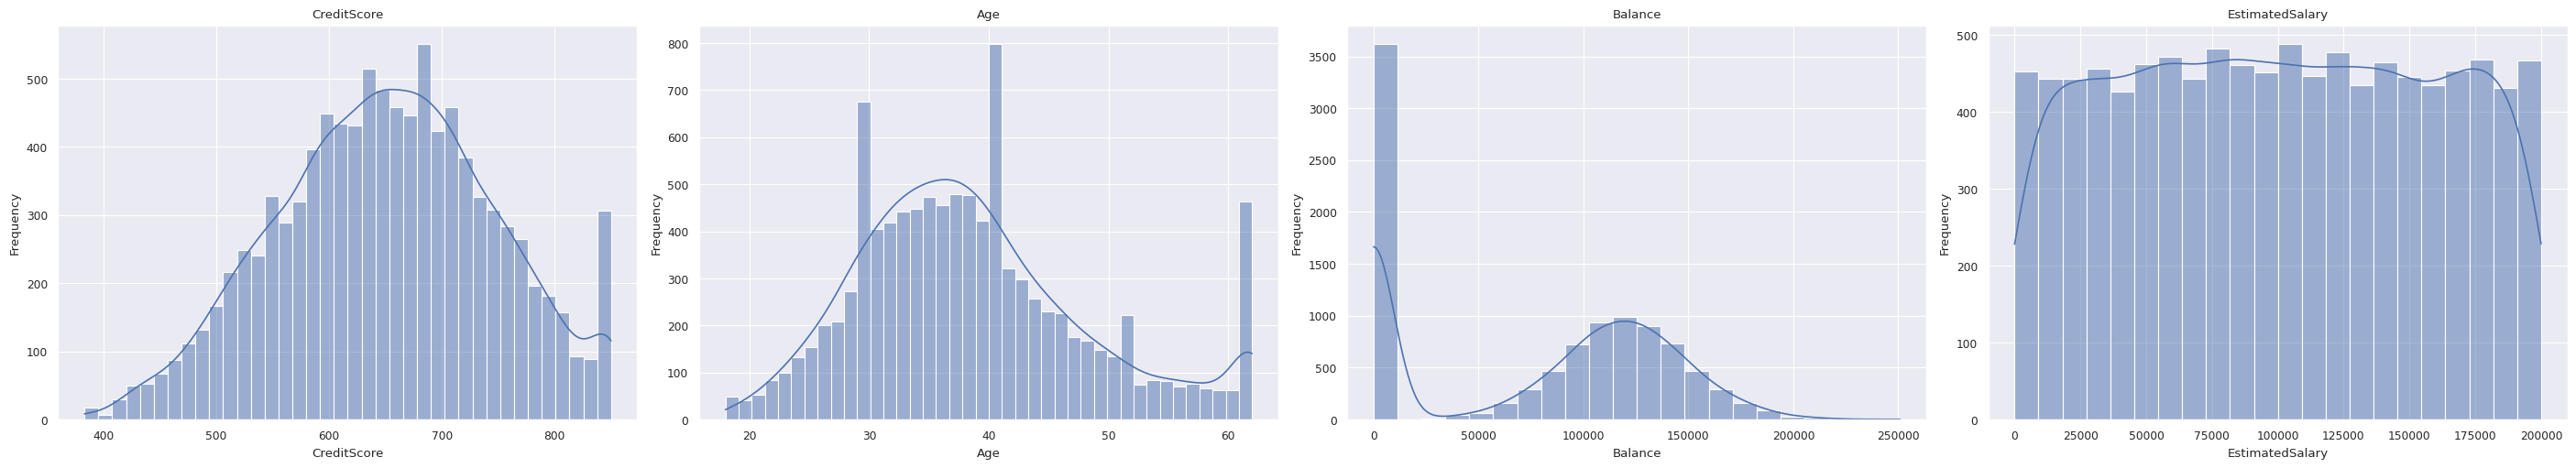

In [ ]:
histplot_columns = ['CreditScore', 'Age', 'Balance','EstimatedSalary']
fig, axes = plt.subplots(1, len(histplot_columns), figsize=(28, 5), constrained_layout=True)
# Plot each column
for i, col in enumerate(histplot_columns):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

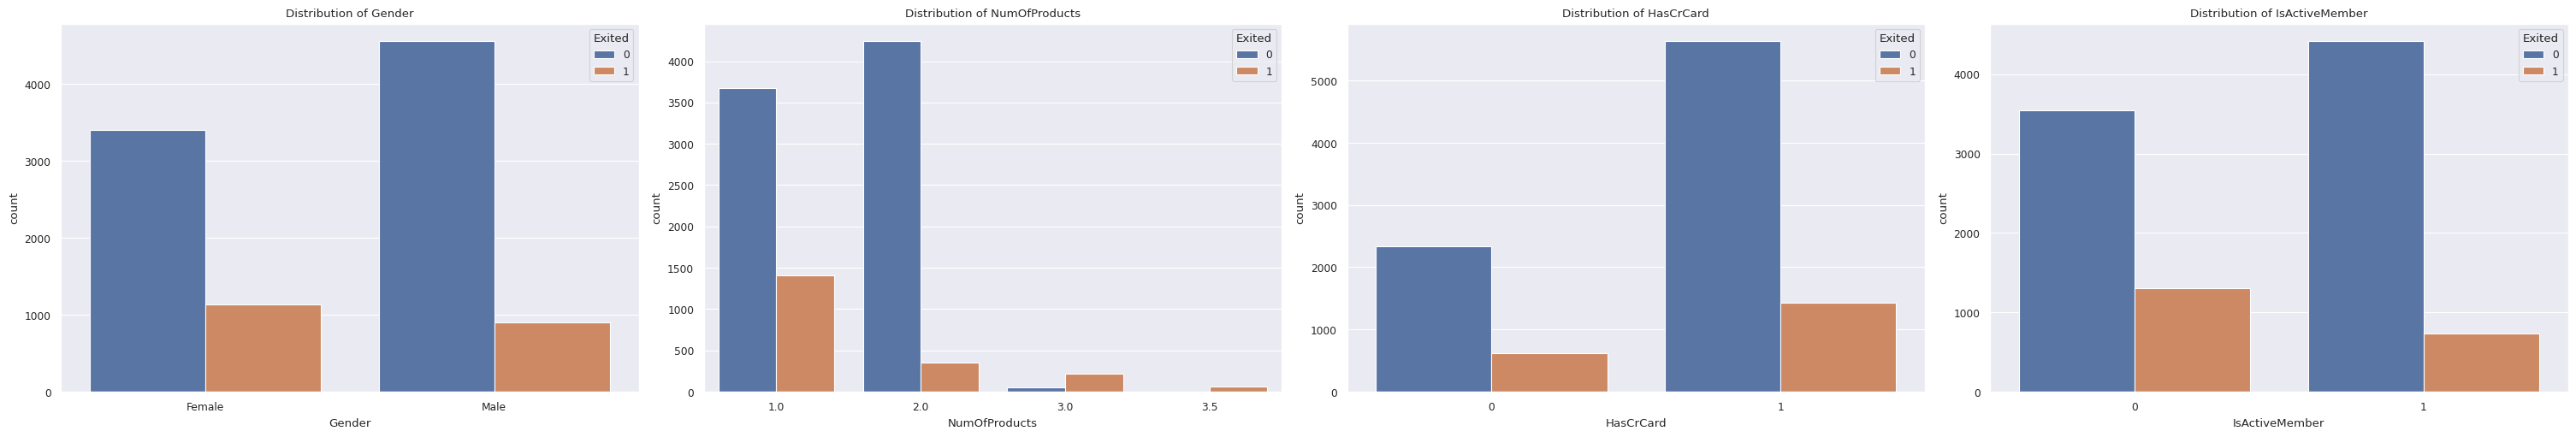

In [ ]:
barplot_cols=[ 'Gender','NumOfProducts', 'HasCrCard','IsActiveMember']
fig, axes = plt.subplots(1, len(barplot_cols), figsize=(30, 5), constrained_layout=True)
# Plot each column
for i, col in enumerate(barplot_cols):
    sns.countplot(x=df[col],hue=df['Exited'], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
plt.show()

In [ ]:
numerical_data=df.select_dtypes(include=['float','int'])
correlation_with_target=numerical_data.corr()['Exited'].sort_values(ascending=False)
print(correlation_with_target)

Exited             1.000000
Age                0.312436
Balance            0.118533
EstimatedSalary    0.012097
HasCrCard         -0.007138
Tenure            -0.014001
CreditScore       -0.026455
NumOfProducts     -0.059196
IsActiveMember    -0.156128
Name: Exited, dtype: float64


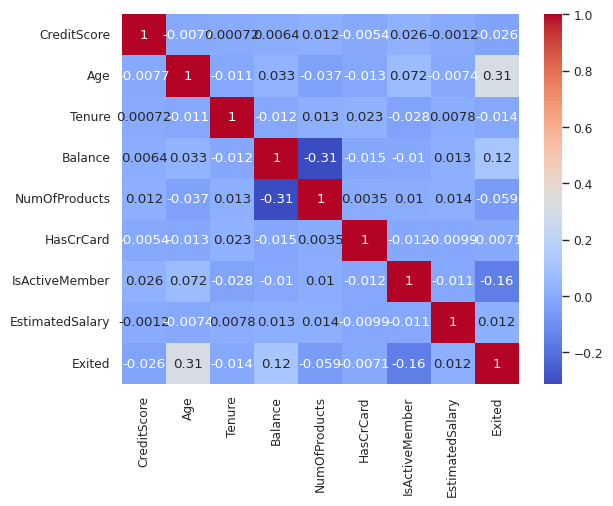

In [ ]:
numerical_data=df.select_dtypes(include=['float','int'])
sns.heatmap(numerical_data.corr(),annot=True,cmap='coolwarm')
plt.show()

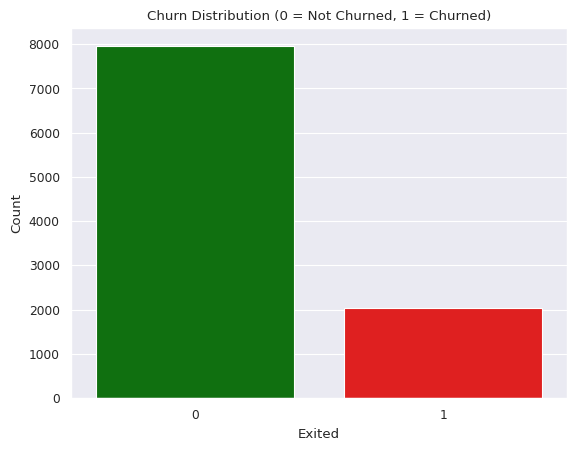

In [ ]:
sns.countplot(x='Exited', data=df, palette=['green', 'red'])
plt.title("Churn Distribution (0 = Not Churned, 1 = Churned)")
plt.xlabel("Exited")
plt.ylabel("Count")
plt.show()

In [ ]:
 from scipy.stats import chi2_contingency, mannwhitneyu
 from scipy.stats import probplot

In [ ]:
# Chi-Square Test: Gender vs Churn
contingency_table = pd.crosstab(df['Gender'], df['Exited'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Test (Gender vs Churn): stat={chi2:.2f}, p-value={p:.5f}")


Chi-Square Test (Gender vs Churn): stat=112.92, p-value=0.00000


In [ ]:
# Chi-Square Test: Geography vs Churn
contingency_table_geo = pd.crosstab(df['Geography'], df['Exited'])
chi2_geo, p_geo, _, _ = chi2_contingency(contingency_table_geo)
print(f"Chi-Square Test (Geography vs Churn): stat={chi2_geo:.2f}, p-value={p_geo:.5f}")


Chi-Square Test (Geography vs Churn): stat=301.26, p-value=0.00000


In [ ]:
# Mann-Whitney U Test: Balance vs Churn
churned = df[df['Exited'] == 1]['Balance']
not_churned = df[df['Exited'] == 0]['Balance']
u_stat, p_u = mannwhitneyu(churned, not_churned, alternative='two-sided')
print(f"Mann-Whitney U Test (Balance vs Churn): U={u_stat}, p-value={p_u:.5f}")


Mann-Whitney U Test (Balance vs Churn): U=9371186.5, p-value=0.00000


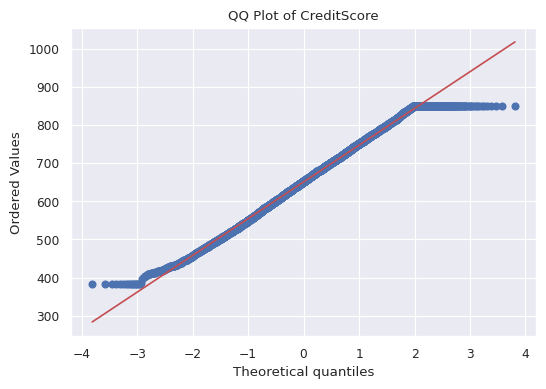

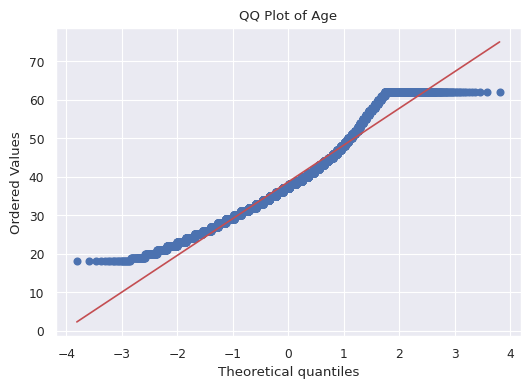

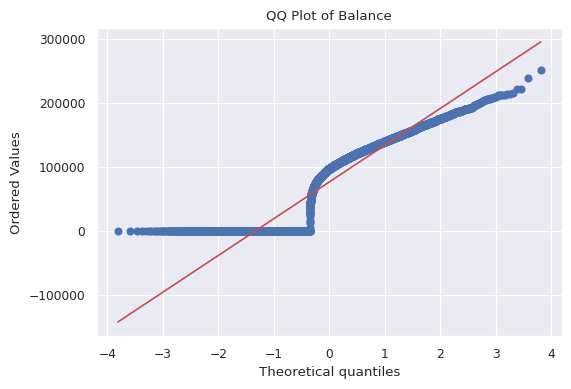

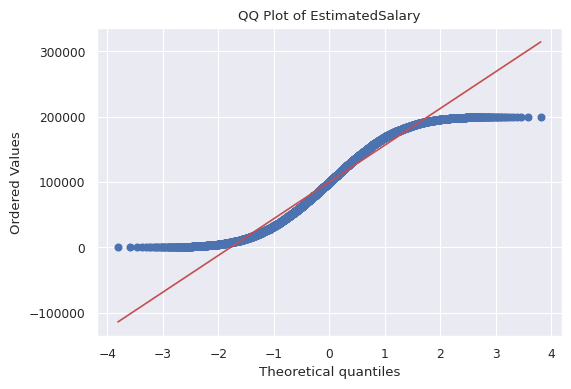

In [ ]:
# QQ Plots for Normality Check
for col in ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']:
    plt.figure(figsize=(6,4))
    probplot(df[col], dist="norm", plot=plt)
    plt.title(f'QQ Plot of {col}')
    plt.show()

In [ ]:
print(df[['Balance', 'EstimatedSalary','CreditScore','Age']].skew())

Balance           -0.141109
EstimatedSalary    0.002085
CreditScore       -0.064255
Age                0.630315
dtype: float64


In [ ]:
# For the gender we will map it to 0 & 1 , so Femals : 0 , Males : 1

df["Gender"] = df["Gender"].map({'Female': 0, 'Male': 1})
# For the Geography we will use the one hot encoding technique
df = pd.get_dummies(df, columns=["Geography"])


In [ ]:
X=df.drop(columns=['Exited'])
y=df['Exited']

In [ ]:
# VarianceThreshold for feature selection (removes features with low variance)
var_thres=VarianceThreshold(threshold=0.05)
var_thres.fit_transform(X)
selected_features_var=X.columns[var_thres.get_support()]
print(selected_features_var)

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_France',
       'Geography_Germany', 'Geography_Spain'],
      dtype='object')


In [ ]:
# Chi-square test for feature selection
selector = SelectKBest(chi2, k=5)
X_chi2 = selector.fit_transform(X, y)
selected_features_chi2 = X.columns[selector.get_support()]
print(selected_features_chi2)

Index(['Age', 'Balance', 'IsActiveMember', 'EstimatedSalary',
       'Geography_Germany'],
      dtype='object')


In [ ]:
# Mutual Information
selector = SelectKBest(mutual_info_classif, k=10)
X_mi = selector.fit_transform(X, y)
selected_features_mi = X.columns[selector.get_support()]
print(selected_features_mi)

Index(['CreditScore', 'Gender', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_France',
       'Geography_Germany'],
      dtype='object')


In [ ]:

# Random Forest Feature Importance
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance)

              feature  importance
2                 Age    0.234867
8     EstimatedSalary    0.146262
0         CreditScore    0.144182
4             Balance    0.143828
5       NumOfProducts    0.128500
3              Tenure    0.083218
7      IsActiveMember    0.040484
10  Geography_Germany    0.021887
6           HasCrCard    0.019064
1              Gender    0.018558
9    Geography_France    0.010249
11    Geography_Spain    0.008901


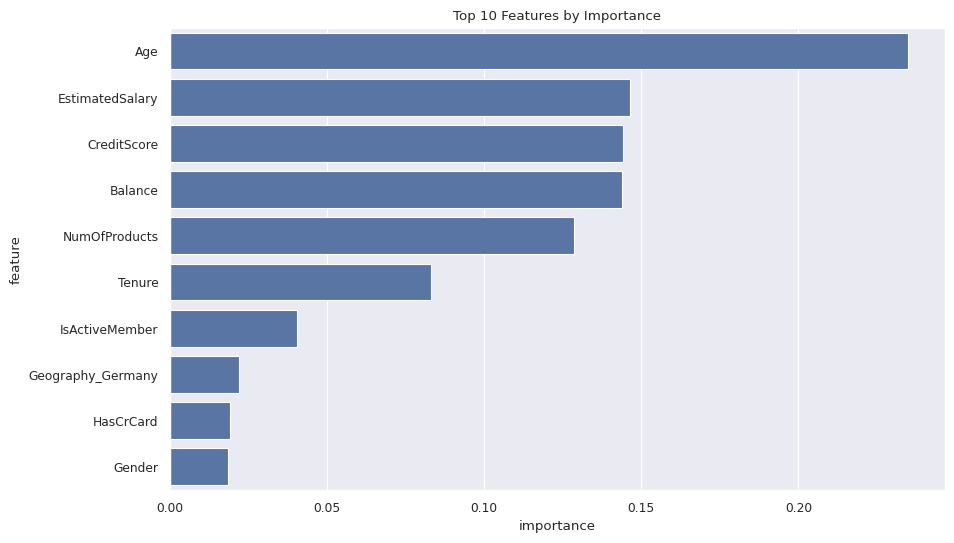

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title("Top 10 Features by Importance")
plt.show()

In [ ]:
# Print selected features
print("Selected features (Variance Threshold):", selected_features_var)
print()
print("Selected features (Chi-square):", selected_features_chi2)
print()
print("Selected features (Mutual Information):", selected_features_mi)
print()
print("Top 10 features (Random Forest):", feature_importance['feature'].head(10).tolist())


Selected features (Variance Threshold): Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_France',
       'Geography_Germany', 'Geography_Spain'],
      dtype='object')

Selected features (Chi-square): Index(['Age', 'Balance', 'IsActiveMember', 'EstimatedSalary',
       'Geography_Germany'],
      dtype='object')

Selected features (Mutual Information): Index(['CreditScore', 'Gender', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_France',
       'Geography_Germany'],
      dtype='object')

Top 10 features (Random Forest): ['Age', 'EstimatedSalary', 'CreditScore', 'Balance', 'NumOfProducts', 'Tenure', 'IsActiveMember', 'Geography_Germany', 'HasCrCard', 'Gender']


In [ ]:
top_10_features_rf = feature_importance['feature'].head(10).tolist()
common_features = set(selected_features_var) & set(selected_features_chi2) & set(selected_features_mi) & set(top_10_features_rf)


In [ ]:
# Print the common selected features
print("Common selected features across all methods:", list(common_features))

Common selected features across all methods: ['IsActiveMember', 'Geography_Germany', 'Balance', 'Age', 'EstimatedSalary']


In [ ]:
X = df[list(common_features)]  # Select only the common features
y = df['Exited']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
# Store results for all models
results = {}
# List of classifiers with their respective hyperparameter grids
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

In [ ]:
param_grids = {
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 5, 10, 15],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'Logistic Regression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__max_iter': [100, 200, 500]
    },
    'SVM': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf', 'poly'],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__degree': [3, 4, 5]
    },
    'Naive Bayes': {
        'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 5, 10, 15, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__criterion': ['gini', 'entropy']
    }
}

In [ ]:
# Store the best results
best_score = 0
best_model_name = ''
best_model = None

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Perform GridSearchCV for each model and record the results
for model_name, classifier in classifiers.items():
    param_grid = param_grids[model_name]

    numerical_col = [col for col in common_features if col in df.select_dtypes(include=['int', 'float']).columns]
    categorical_col = [col for col in common_features if col in df.select_dtypes(include=['object']).columns]


    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numerical_col),
        ('cat', categorical_transformer, categorical_col)
    ])

    # Define the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Assuming preprocessor is defined earlier
        ('classifier', classifier)
    ])
    # Perform GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best model and its score
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_

    # Store the results
    results[model_name] = {
        'best_params': best_params,
        'best_accuracy': best_accuracy,
        'best_estimator': best_estimator
    }

     # Update the best model based on accuracy
    if best_accuracy > best_score:
        best_score = best_accuracy
        best_model_name = model_name
        best_model = best_estimator



In [ ]:
# Display the results
print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {best_score}")
print(f"Best Params: {results[best_model_name]['best_params']}")

In [ ]:
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test F1 Score: {f1_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

In [ ]:
# Save the best model and its parameters to a pickle file
with open('best_model.pkl', 'wb') as f:
    pickle.dump({
        'best_model': best_model,
        'best_params': results[best_model_name]['best_params']
    }, f)

print("Best model and its parameters have been saved to 'best_model.pkl'.")